In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "careamics[examples]>=0.0.15",
# ]
# ///

## The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of Noise2Void and N2V2, an extension of Noise2Void,
on this particular dataset!

In [12]:
# Imports necessary to execute the code
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics_portfolio import PortfolioManager
from PIL import Image

In [13]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

Using GPU: yes


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [14]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)

### Data description

In [15]:
portfolio.denoising.N2V_SEM.description

'Cropped images from a SEM dataset from T.-O. Buchholz et al (Methods Cell Biol, 2020).'

## Visualize data

Text(0.5, 1.0, 'Validation Image')

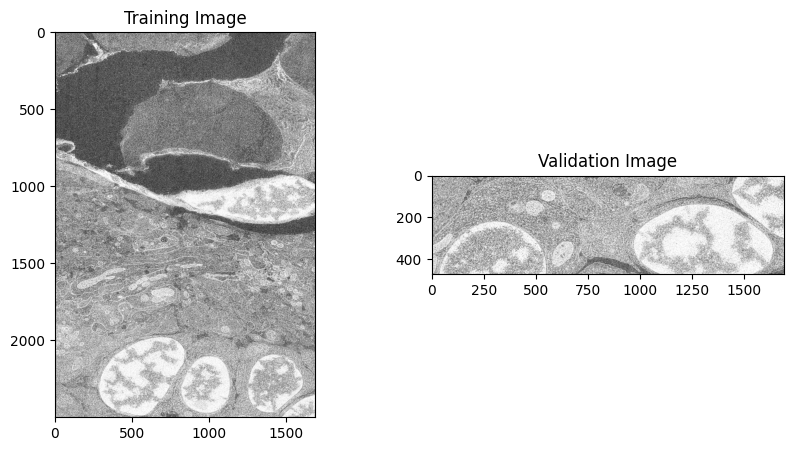

In [16]:
# load training and validation image and show them side by side
train_image = tifffile.imread(files[0])
val_image = tifffile.imread(files[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

There the switch between Noise2Void and N2V2 is done by changing the `use_n2v2` parameter.

In [17]:
use_n2v2 = False
algo = "n2v2" if use_n2v2 else "n2v"

config = create_n2v_configuration(
    experiment_name=f"sem_{algo}",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=30,
    use_n2v2=use_n2v2,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [18]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    val_source=val_image,
)

No working directory provided. Using current working directory: /localscratch/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Computed dataset mean: [39216.047], std: [18678.184]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Show loss.

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


Text(0.5, 1.0, 'Losses')

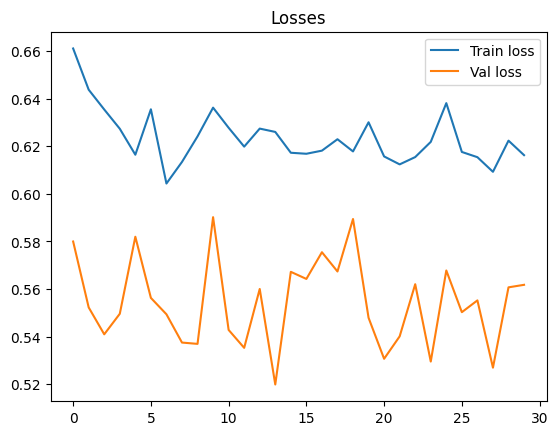

In [19]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [8]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-nvpt4s-9-5904a58d5cc194a0/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

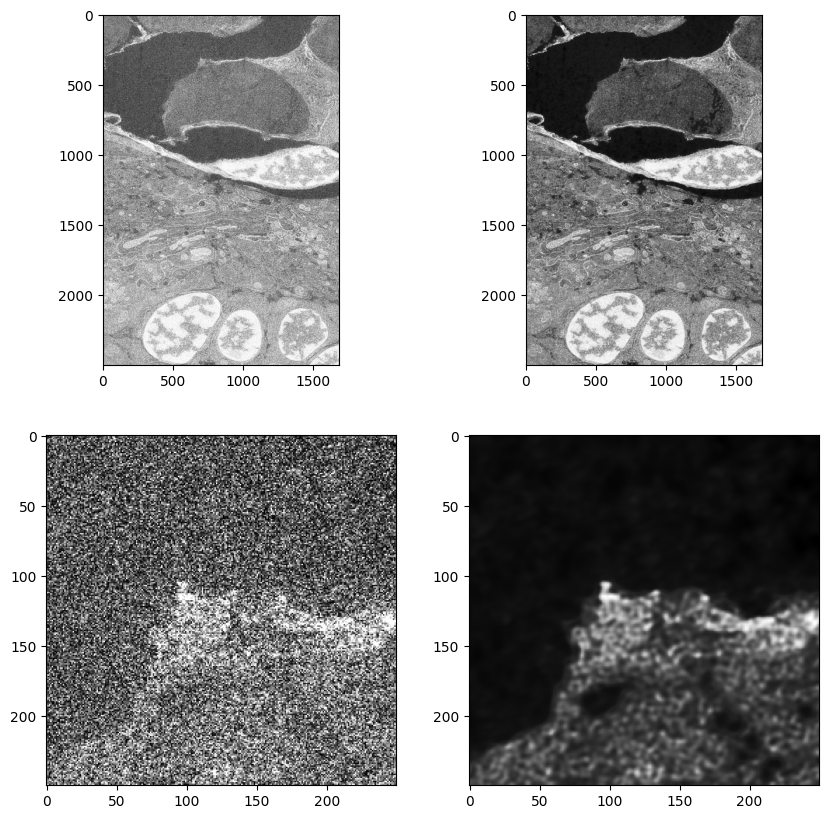

In [9]:
# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction[0].squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the [BioImage Model Zoo](www.bioimage.io)
format.

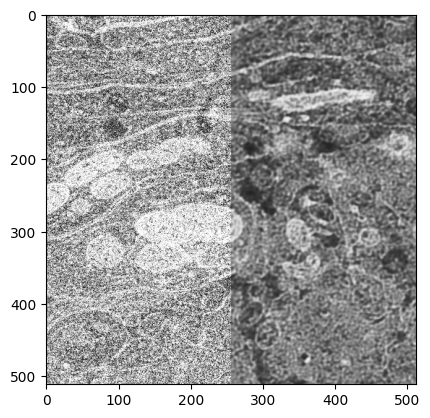

In [20]:
# create a cover image
x_start, width = 500, 512
y_start, height = 1400, 512

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (train_image - train_image.min()) / (train_image.max() - train_image.min())

pred = prediction[0].squeeze()
norm_pred = (pred - pred.min()) / (pred.max() - pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[
    y_start : y_start + height, x_start : x_start + width // 2
]
cover[:, width // 2 :] = norm_pred[
    y_start : y_start + height, x_start + width // 2 : x_start + width
]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save(f"SEM_{algo}.jpeg")

In [2]:
general_description = (
    "This model is a UNet trained using the Noise2Void algorithm to denoise images."
    "The training data consists of crops "
    "from an SEM dataset (T.-O. Buchholz et al., Methods Cell Biol, 2020). The "
    "notebook used to train this model is available on the CAREamics documentation "
    "website at the following link: "
    "https://careamics.github.io/0.1/applications/N2V2/SEM/."
)
print(general_description)

This model is a UNet trained using the Noise2Void algorithm to denoise images.The training data consists of crops from an SEM dataset (T.-O. Buchholz et al., Methods Cell Biol, 2020). The notebook used to train this model is available on the CAREamics documentation website at the following link: https://careamics.github.io/0.1/applications/N2V2/SEM/.


In [11]:
# Export the model",
careamist.export_to_bmz(
    path_to_archive=f"sem_{algo}_model.zip",
    friendly_model_name=f"SEM_{algo}",
    input_array=train_image[1400:1656, 500:756],
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description=portfolio.denoising.N2V_SEM.description
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]






2025-01-23 15:04:00.636 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found in /home/melisande.croft/.careamics/README.md.
2025-01-23 15:04:00.656 | INFO     | bioimageio.core._resource_tests:_test_model_inference:226 - starting 'Reproduce test outputs from test inputs (pytorch_state_dict)'
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/bioimageio/core/model_adapters/_pytorch_model_adapter.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arb